# Fingerprinting a flood: forensic statistical analysis of the mid-2021 Monero transaction volume anomaly

Contributors: Isthmus (Mitchell P. Krawiec-Thayer), Neptune, Rucknium, Jberman, Carrington

Correspondence: isthmus@getmonero.org

This notebook contains the exploratory data analysis that generated the figures in the article [Fingerprinting a flood: forensic statistical analysis of the mid-2021 Monero transaction volume anomaly](https://mitchellpkt.medium.com/fingerprinting-a-flood-forensic-statistical-analysis-of-the-mid-2021-monero-transaction-volume-a19cbf41ce60). That article is recommended reading for describing the rationale and interpretation of the code and plots below (the commentary is sparser in this notebook). This was a late night side project, so please forgive that the code is not polished. 

## Import Libraries
(if you have any issues with the next cell, run `pip install -r requirements.txt` in your terminal to install dependencies)

In [3]:
import isthmuslib as isli
import pandas as pd
import os as os
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import numpy as np
import statsmodels.api as sm
from copy import deepcopy
from typing import List, Dict

## Set parameters

Filepaths

In [4]:
data_file_path = os.path.join(os.path.curdir,  'data')
data_file_name = 'transaction_attributes.csv'  # Thanks @ Neptune Research

Plotting

In [5]:
excess_start_height: int = 2409000
excess_start_offset: int = 201
standard_figure_size: List[float] = [11, 7]

event_markers: Dict[int, str] = {
    2365413: "blue",
    2409000: "red",
    2383730: "green",
}


def add_lines(events: dict = event_markers, linewidth: int = 2):
    [plt.axvline(x=element, linestyle='--', color=events[element], linewidth=linewidth) for element in events.keys()]

Preferences

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
font = {'family': 'normal',
        'weight': 'normal',
        'size': 15}

matplotlib.rc('font', **font)

## Import data

Load from file

In [8]:
df = pd.read_csv(os.path.join(data_file_path, data_file_name))
df.head()

block_height  block_timestamp  tx_index  tx_version  tx_unlock_time  \
0       2264584       1609459423         1           2             0.0   
1       2264584       1609459423         2           2             0.0   
2       2264584       1609459423         3           2             0.0   
3       2264584       1609459423         4           2             0.0   
4       2264584       1609459423         5           2             0.0   

   tx_n_vin  tx_n_vout  tx_len_extra     tx_fee  
0         1          2            44  109900000  
1         1          4           163   95240000  
2         8          2            44  207510000  
3         1          2            44   11980000  
4         1          2            44   11930000

Data overview

In [9]:
df.describe()

block_height  block_timestamp      tx_index  tx_version  \
count  5.368703e+06     5.368703e+06  5.368703e+06   5368703.0   
mean   2.354951e+06     1.620306e+09  3.522527e+01         2.0   
std    5.021346e+04     6.027768e+06  3.383661e+01         0.0   
min    2.264584e+06     1.609459e+09  1.000000e+00         2.0   
25%    2.313900e+06     1.615380e+09  1.000000e+01         2.0   
50%    2.353736e+06     1.620160e+09  2.400000e+01         2.0   
75%    2.401865e+06     1.625938e+09  5.000000e+01         2.0   
max    2.437999e+06     1.630275e+09  2.110000e+02         2.0   

       tx_unlock_time      tx_n_vin     tx_n_vout  tx_len_extra        tx_fee  
count    5.368703e+06  5.368703e+06  5.368703e+06  5.368703e+06  5.368703e+06  
mean     3.195701e+01  2.108453e+00  2.379354e+00  5.367451e+01  2.356976e+08  
std      8.904729e+03  6.708145e+00  1.993671e+00  1.961624e+02  6.452917e+09  
min      0.000000e+00  1.000000e+00  2.000000e+00  3.300000e+01  8.540000e+06  
25%      0.000000e+00  1.000000e+00  2.000000e+00  4.400000e+01  1.073000e+07  
50%      0.000000e+00  1.000000e+00  2.000000e+00  4.400000e+01  1.365000e+07  
75%      0.000000e+00  2.000000e+00  2.000000e+00  4.400000e+01  4.533000e+07  
max      3.384993e+06  2.610000e+02  1.600000e+01  1.336360e+05  4.966000e+12

## Profiling functions

### Apply a filter (if desired) and perform binning + decomposition

In [10]:
def apply_filter_and_analyses(df: pd.DataFrame, df_filter=None, blocks_per_day: int = 720, two_sided: bool = False):
    if df_filter is None:
        df_filter = (df['block_height'] > -1)

    df_og = deepcopy(df)
    df = deepcopy(df[df_filter])

    initial_block: int = min(df['block_height'])
    start_block: int = int(min(df['block_height']))
    end_block: int = int(max(df['block_height']))
    num_days: int = int(np.floor((end_block - start_block) / blocks_per_day))

    bins = [start_block + x * blocks_per_day for x in range(num_days)]
    hist_counts, hist_edges = np.histogram(df['block_height'], bins=bins)
    hist_counts_og, hist_edges_og = np.histogram(df_og['block_height'], bins=bins)
    res = sm.tsa.seasonal_decompose(hist_counts, period=7, two_sided=two_sided)  # weekly trend
    res_og = sm.tsa.seasonal_decompose(hist_counts_og, period=7, two_sided=two_sided)
    return hist_edges[1::], hist_counts, res, res_og, initial_block

### Visualizatons

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


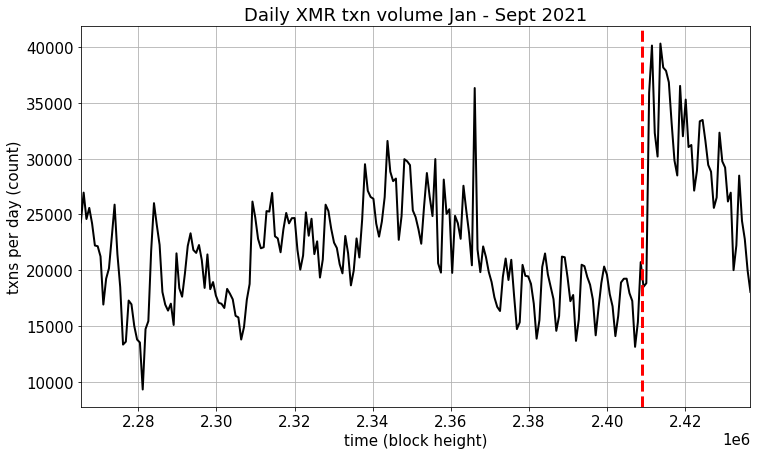

In [11]:
xx, yy, *rest = apply_filter_and_analyses(df)
plt.figure(facecolor='w', figsize=(12, 7))
plt.plot(xx, yy, color='k', linewidth=2)
plt.xlim(isli.bookends(xx, 0))
plt.xlabel('time (block height)')
plt.ylabel('txns per day (count)')
plt.title('Daily XMR txn volume Jan - Sept 2021')
plt.grid('on')
plt.axvline(x=excess_start_height, color='r', linewidth=3, linestyle='--');

### Plot decomposition

In [12]:
def plot_decomposition(res, vline: int = excess_start_height, figsize: List[int] = [8, 3], initial_block: int = 0,
                       blocks_per_day: int = 720,
                       which_plots: List[str] = ['observed', 'trend', 'seasonal', 'residual', 'comparison'],
                       title: str = '', to_add_lines: bool = False, res_og=None, make_plots: bool = True):
    xlabel: str = 'time'
    ylabel: str = 'counts'
    heights: List[int] = [initial_block + x * blocks_per_day for x in range(len(res.observed))]

    if (not res_og is None) and ('comparison' in which_plots):
        zipped = zip(res.trend, res_og.trend)
        res.ratio = [x[0] / x[1] for x in zipped]

    if make_plots:
        # obs
        if 'observed' in which_plots:
            plt.figure(figsize=figsize, facecolor='w')
            plt.plot(heights, res.observed, '-', label='Transaction volume', color='k')
            plt.xlabel(xlabel)
            plt.legend()
            plt.ylabel(ylabel)
            plt.title(title + ' // observed')
            if (not vline is None) and (initial_block > 0):
                plt.axvline(x=vline, color='r', linestyle=':', linewidth=2)
            plt.xlim(isli.bookends(heights, 0))
            if to_add_lines:
                add_lines()

        # trend
        if 'trend' in which_plots:
            plt.figure(figsize=figsize, facecolor='w')
            plt.plot(heights, res.trend, '-', label='Trend', color='green')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend()
            plt.title(title + ' // trend')
            if (not vline is None) and (initial_block > 0):
                plt.axvline(x=vline, color='r', linestyle=':', linewidth=2)
            plt.xlim(isli.bookends(heights, 0))
            if to_add_lines:
                add_lines()

        # seasonal
        if 'seasonal' in which_plots:
            plt.figure(figsize=figsize, facecolor='w')
            plt.plot(heights, res.seasonal, '-', label="Weekly ('Seasonal')", color='darkslateblue')
            plt.xlabel(xlabel)
            plt.ylabel('Weekly cycle (+/- counts)')
            plt.legend()
            plt.title(title + ' // weekly')
            if (not vline is None) and (initial_block > 0):
                plt.axvline(x=vline, color='r', linestyle=':', linewidth=2)
            plt.xlim(isli.bookends(heights, 0))
            if to_add_lines:
                add_lines()

        # residuals
        if 'residual' in which_plots:
            plt.figure(figsize=figsize, facecolor='w')
            plt.plot(heights, res.resid, '-', label='Residual', color='darkred')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.title(title + ' // residual')
            plt.legend()
            if (not vline is None) and (initial_block > 0):
                plt.axvline(x=vline, color='r', linestyle=':', linewidth=2)
            plt.xlim(isli.bookends(heights, 0))
            if to_add_lines:
                add_lines()

        if (not res_og is None) and ('comparison' in which_plots):
            plt.figure(figsize=figsize, facecolor='w')
            plt.plot(heights, [x * 100 for x in res.ratio], '-', label='filtered', color='darkviolet')
            plt.xlabel(xlabel)
            plt.ylabel('Prevalence (%)')
            plt.title(title + ' // prevalence')
            plt.legend()
            if (not vline is None) and (initial_block > 0):
                plt.axvline(x=vline, color='r', linestyle=':', linewidth=2)
            plt.xlim(isli.bookends(heights, 0))
            if to_add_lines:
                add_lines()

        return res

### Filters

In [13]:
def plot_filtered_versions(df: pd.DataFrame, filter_dict: dict,
                           which_plots: List[str] = ['observed', 'trend', 'seasonal', 'residual', 'comparison'],
                           to_add_lines: bool = False):
    for key in filter_dict.keys():
        *rest, res, res_og, ib = apply_filter_and_analyses(df, df_filter=filter_dict[key])
        plot_decomposition(res, initial_block=ib, which_plots=which_plots, title=key, res_og=res_og,
                           to_add_lines=add_lines)

## Examine various characteristics

Control case, N outputs == 11

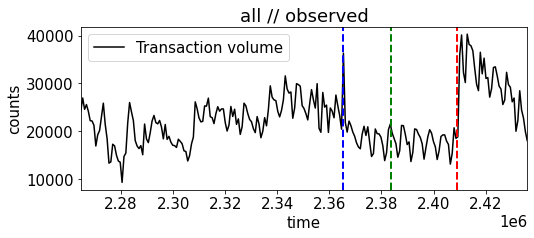

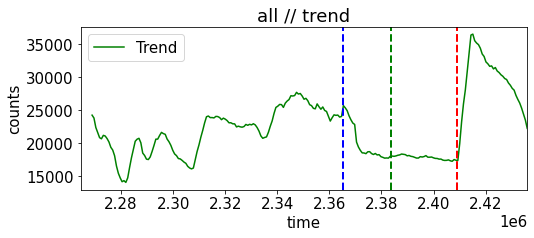

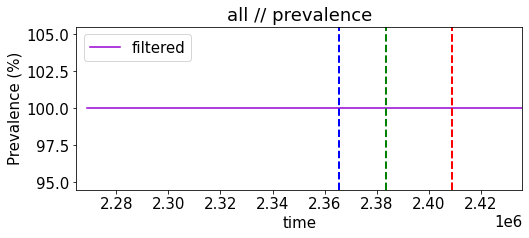

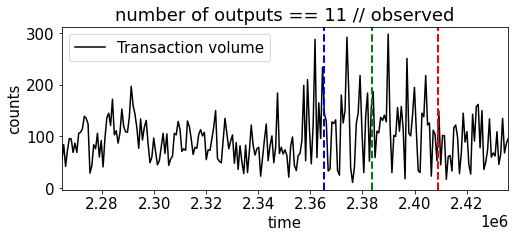

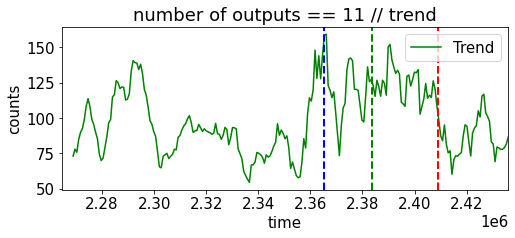

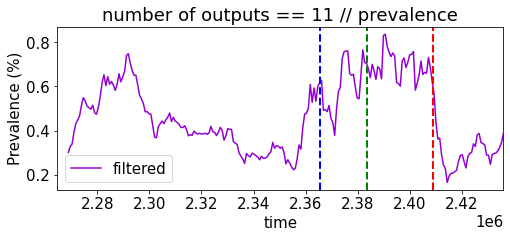

In [14]:
filter_dict: dict = {
    "all": (df['block_height'] > -1),
    "number of outputs == 11": (df['tx_n_vout'] == 11)
}
plot_filtered_versions(df, filter_dict, which_plots=['observed', 'trend', 'comparison'])

### Number of inputs??

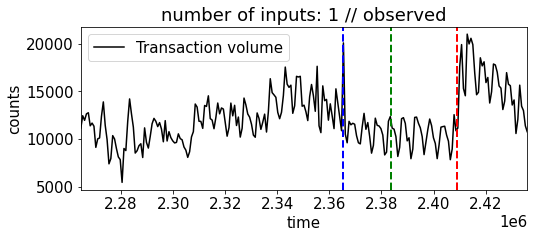

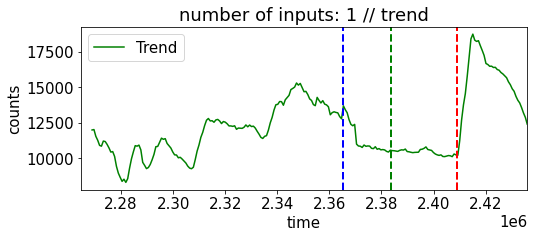

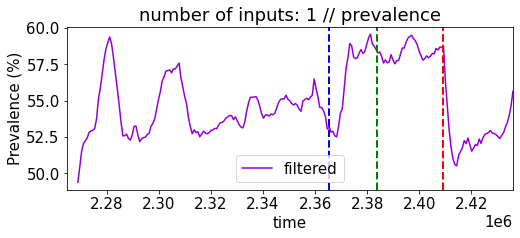

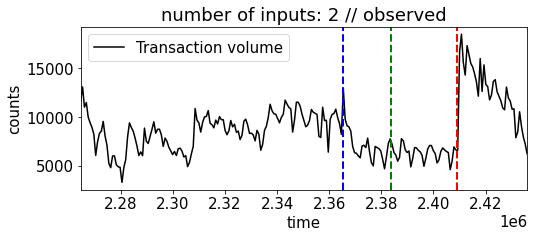

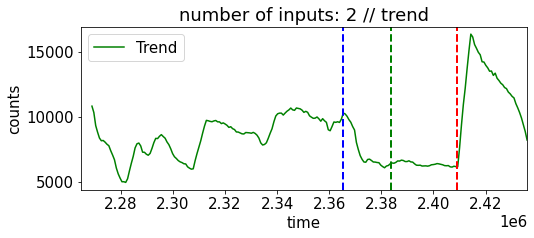

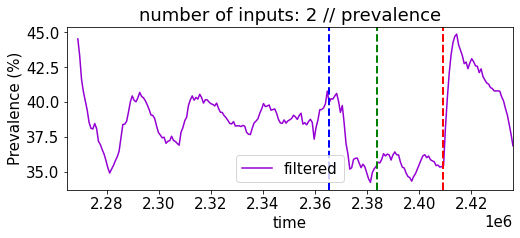

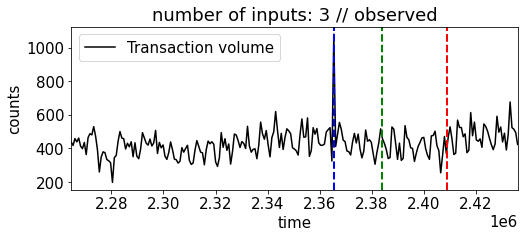

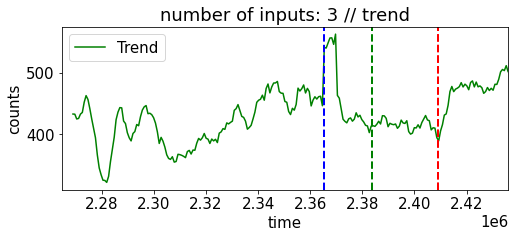

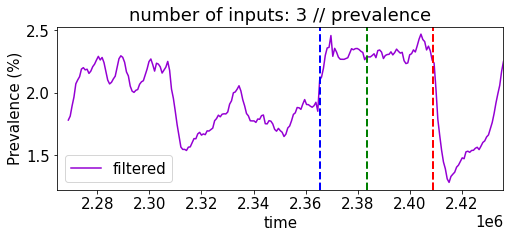

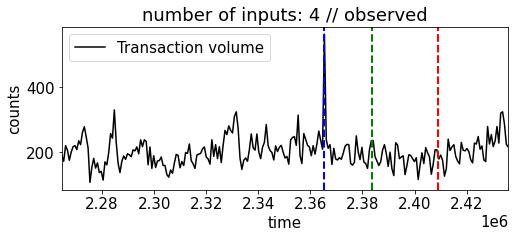

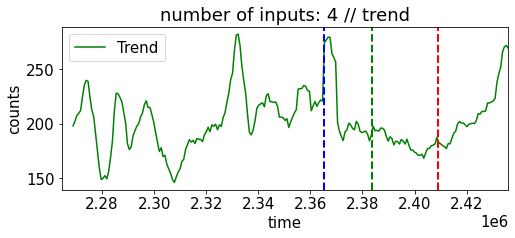

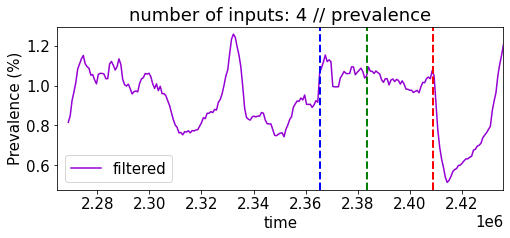

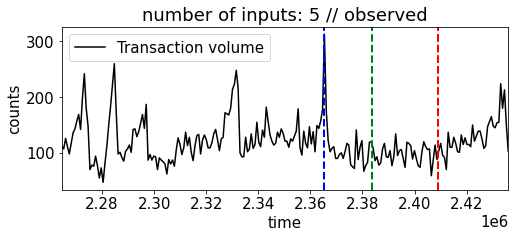

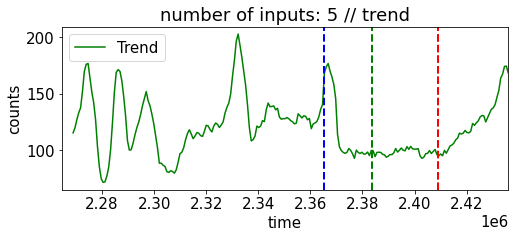

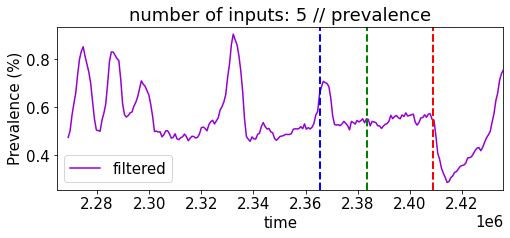

In [15]:
filter_dict: dict = {}
max_num_inputs_to_look_at: int = 5
for n in range(1, max_num_inputs_to_look_at + 1):
    filter_dict[f"number of inputs: {n}"] = (df['tx_n_vin'] == n)
plot_filtered_versions(df, filter_dict, which_plots=['observed', 'trend', 'comparison'])

Compare the counts for number of inputs

No handles with labels found to put in legend.


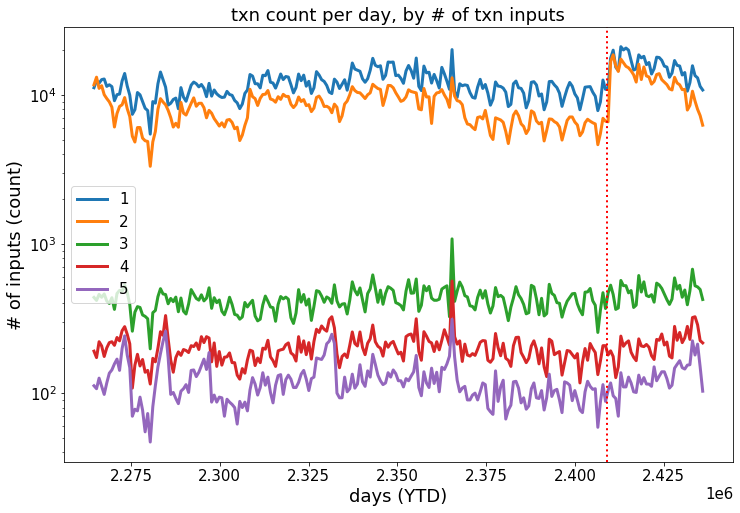

In [16]:
num_inputs_max: int = 5
plt.figure(figsize=(12, 8), facecolor='w')
for n in range(1, num_inputs_max + 1):
    df_filter = (df['tx_n_vin'] == n)
    xx, yy, res, _, ib = apply_filter_and_analyses(df, df_filter=df_filter)
    # plt.scatter([x*720 + ib for x in range(len(res.observed))],res.observed, s=3, color='gray')
    plt.plot([x * 720 + ib for x in range(len(res.observed))], res.observed, linewidth=3);
plt.legend()
plt.yscale('log')
plt.legend([str(x) for x in range(1, num_inputs_max + 1)] + ['data points'])
plt.xlabel('days (YTD)', size=18)
plt.ylabel('# of inputs (count)', size=18)
plt.title('txn count per day, by # of txn inputs', size=18)
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2);

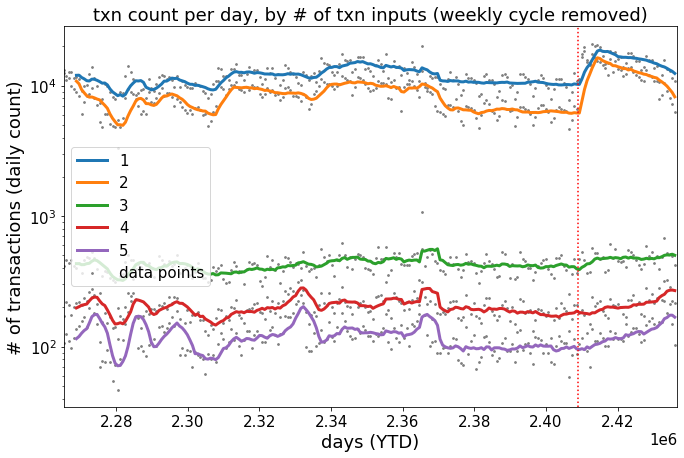

In [17]:
num_inputs_max: int = 5
plt.figure(figsize=standard_figure_size, facecolor='w')
for n in range(1, num_inputs_max + 1):
    df_filter = (df['tx_n_vin'] == n)
    xx, yy, res, _, ib = apply_filter_and_analyses(df, df_filter=df_filter)
    plt.scatter([x * 720 + ib for x in range(len(res.observed))], res.observed, s=3, color='gray')
    plt.plot([x * 720 + ib for x in range(len(res.observed))], res.trend, linewidth=3);
plt.yscale('log')
plt.legend([str(x) for x in range(1, num_inputs_max + 1)] + ['data points'])
plt.xlabel('days (YTD)', size=18)
plt.ylabel('# of transactions (daily count)', size=18)
plt.title('txn count per day, by # of txn inputs (weekly cycle removed)', size=18)
#plt.axvline(x=excess_start, color='r', linestyle=':', linewidth=2);
plt.xlim(isli.bookends(xx, 0));
#[plt.axvline(x=element, linestyle=':', color=events[element]) for element in list(set(events.keys())-set([2365413]))]
plt.axvline(x=excess_start_height, color='r', linestyle=':');

In [18]:
def normalize_array(X: list) -> List[float]:
    """  Normalize an array to unit mean and standard deviation"""
    X_mean: float = float(np.nanmean(X))
    centered: List[float] = [x - X_mean for x in X]
    X_std: float = float(np.nanstd(X))
    return [x / X_std for x in centered]

Compare the ratios for number of inputs

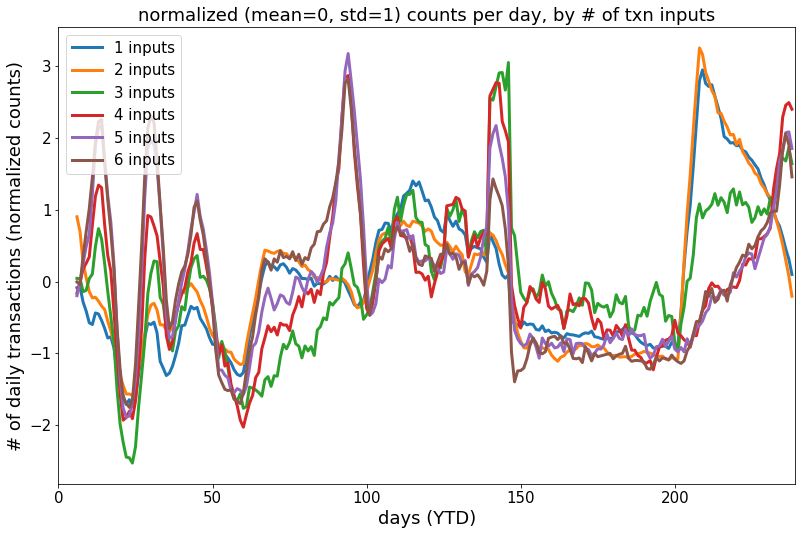

In [19]:
# Calculate the normalized amounts

filter_dict: dict = {}
max_num_inputs_to_look_at: int = 6
reslist: list = list()
for n in range(1, max_num_inputs_to_look_at + 1):
    df_filter = (df['tx_n_vin'] == n)
    _, _, res, res_og, initial_block = apply_filter_and_analyses(df, df_filter=df_filter)
    res_augmented = plot_decomposition(res, blocks_per_day=720, res_og=res_og, make_plots=False)
    reslist.append(res)

# Plot
plt.figure(figsize=[x * 1.2 for x in standard_figure_size], facecolor='w')
for r in reslist:
    n_trend = normalize_array(r.trend)
    plt.plot(n_trend, linewidth=3)

plt.legend([str(x) + ' inputs' for x in range(1, max_num_inputs_to_look_at + 1)], loc='upper left')
plt.xlabel('days (YTD)', size=18)
plt.ylabel('# of daily transactions (normalized counts)', size=18)
plt.title('normalized (mean=0, std=1) counts per day, by # of txn inputs', size=18);
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.xlim(0, len(r.ratio));

No handles with labels found to put in legend.


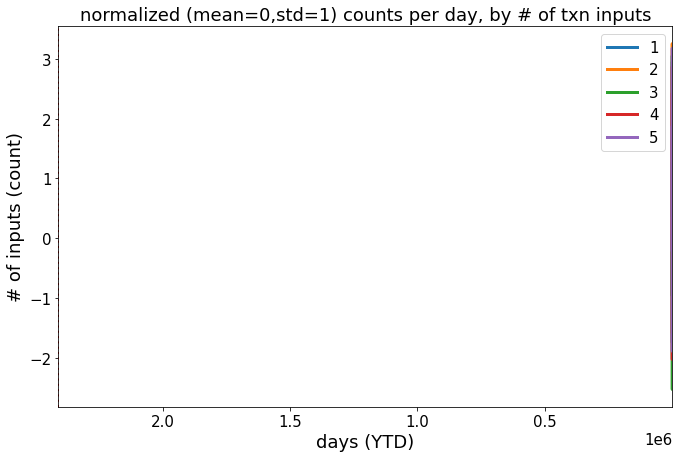

In [20]:
# Calculate the normalized amounts

filter_dict: dict = {}
max_num_inputs_to_look_at: int = 5
reslist: list = list()
for n in range(1, max_num_inputs_to_look_at + 1):
    df_filter = (df['tx_n_vin'] == n)
    _, _, res, res_og, initial_block = apply_filter_and_analyses(df, df_filter=df_filter)
    res_augmented = plot_decomposition(res, blocks_per_day=720, res_og=res_og, make_plots=False)
    reslist.append(res)

# Plot
plt.figure(figsize=standard_figure_size, facecolor='w')
for r in reslist:
    n_trend = normalize_array(r.trend)
    plt.plot(n_trend, linewidth=3)

plt.legend()
plt.legend([str(x) for x in range(1, max_num_inputs_to_look_at + 1)])
plt.xlabel('days (YTD)', size=18)
plt.ylabel('# of inputs (count)', size=18)
plt.title('normalized (mean=0,std=1) counts per day, by # of txn inputs', size=18);
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.xlim(excess_start_height - 5, len(r.ratio));

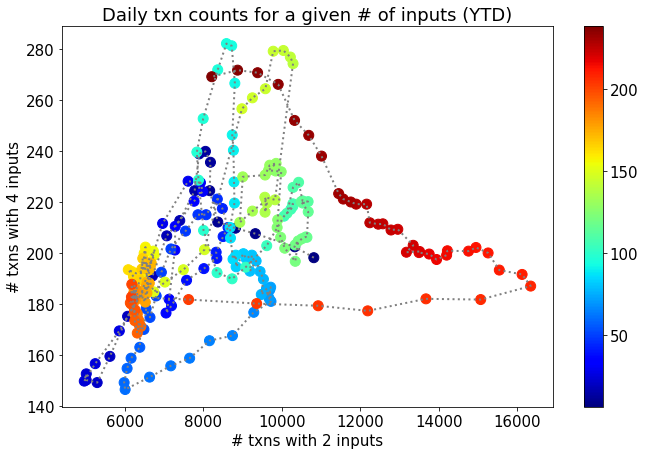

In [21]:
# Calculate the normalized amounts
c1 = 1  # 2 inputs
c2 = 3  # 4 inputs

x = reslist[c1].trend
y = reslist[c2].trend

plt.figure(figsize=standard_figure_size, facecolor='w')
plt.plot(x, y, color='gray', linewidth=2, linestyle=':')
plt.scatter(x, y, 100, range(len(x)), cmap='jet')
plt.colorbar()
plt.title('Daily txn counts for a given # of inputs (YTD)')
plt.xlabel('# txns with 2 inputs')
plt.ylabel('# txns with 4 inputs');

No handles with labels found to put in legend.


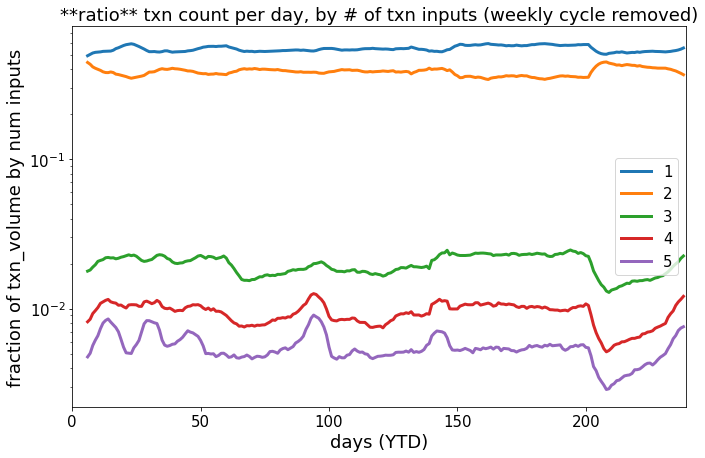

In [22]:
# Calculate the ratios

filter_dict: dict = {}
max_num_inputs_to_look_at: int = 5
reslist: list = list()
for n in range(1, max_num_inputs_to_look_at + 1):
    df_filter = (df['tx_n_vin'] == n)
    _, _, res, res_og, initial_block = apply_filter_and_analyses(df, df_filter=df_filter)
    res_augmented = plot_decomposition(res, blocks_per_day=720, res_og=res_og, make_plots=False)
    reslist.append(res)

# Plot
plt.figure(figsize=standard_figure_size, facecolor='w')
for r in reslist:
    plt.plot(r.ratio, linewidth=3)

plt.legend()
plt.yscale('log')
plt.legend([str(x) for x in range(1, max_num_inputs_to_look_at + 1)])
plt.xlabel('days (YTD)', size=18)
plt.ylabel('fraction of txn_volume by num inputs', size=18)
plt.title('**ratio** txn count per day, by # of txn inputs (weekly cycle removed)', size=18);
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2);
plt.xlim(0, len(r.ratio));
[plt.axvline(x=element, linestyle=':', color=event_markers[element]) for element in event_markers.keys()];

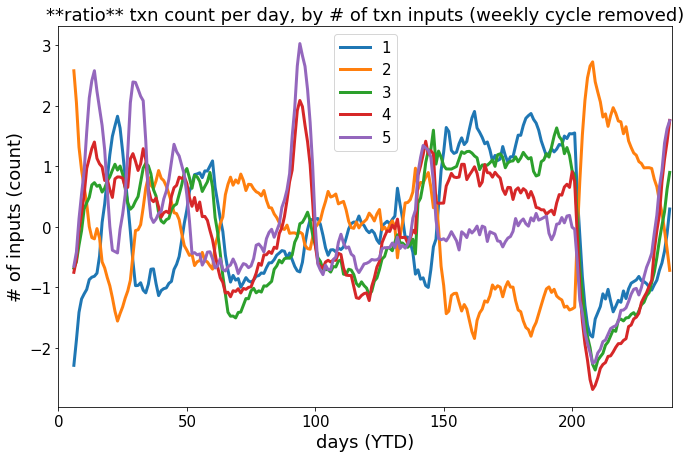

In [23]:
# Calculate the normalized ratios

filter_dict: dict = {}
max_num_inputs_to_look_at: int = 5
reslist: list = list()
for n in range(1, max_num_inputs_to_look_at + 1):
    df_filter = (df['tx_n_vin'] == n)
    _, _, res, res_og, initial_block = apply_filter_and_analyses(df, df_filter=df_filter)
    res_augmented = plot_decomposition(res, blocks_per_day=720, res_og=res_og, make_plots=False)
    reslist.append(res)

# Plot
plt.figure(figsize=standard_figure_size, facecolor='w')
for r in reslist:
    ratio = r.ratio
    n_ratio = normalize_array(ratio)
    plt.plot(n_ratio, linewidth=3)

plt.legend([str(x) for x in range(1, max_num_inputs_to_look_at + 1)])
plt.xlabel('days (YTD)', size=18)
plt.ylabel('# of inputs (count)', size=18)
plt.title('**ratio** txn count per day, by # of txn inputs (weekly cycle removed)', size=18);
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.xlim(0, len(r.ratio));

No handles with labels found to put in legend.


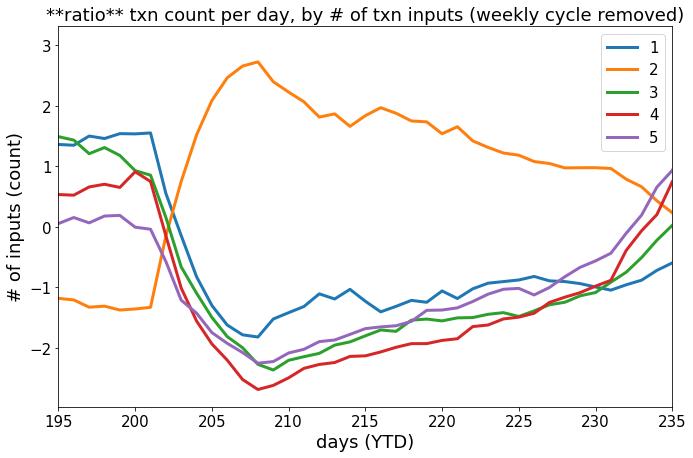

In [24]:
# Calculate the normalized ratios

filter_dict: dict = {}
max_num_inputs_to_look_at: int = 5
reslist: list = list()
for n in range(1, max_num_inputs_to_look_at + 1):
    df_filter = (df['tx_n_vin'] == n)
    _, _, res, res_og, initial_block = apply_filter_and_analyses(df, df_filter=df_filter)
    res_augmented = plot_decomposition(res, blocks_per_day=720, res_og=res_og, make_plots=False)
    reslist.append(res)

# Plot
plt.figure(figsize=standard_figure_size, facecolor='w')
for r in reslist:
    ratio = r.ratio
    n_ratio = normalize_array(ratio)
    plt.plot(n_ratio, linewidth=3)

plt.legend()
plt.legend([str(x) for x in range(1, max_num_inputs_to_look_at + 1)])
plt.xlabel('days (YTD)', size=18)
plt.ylabel('# of inputs (count)', size=18)
plt.title('**ratio** txn count per day, by # of txn inputs (weekly cycle removed)', size=18);
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.xlim((195, 235))
[plt.axvline(x=element, linestyle=':', color=event_markers[element]) for element in event_markers.keys()];

## Outputs

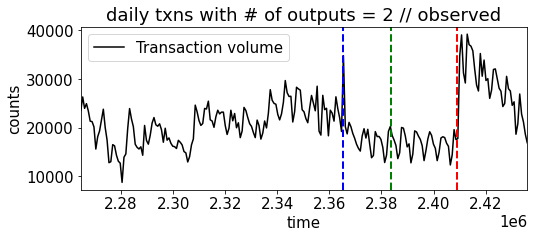

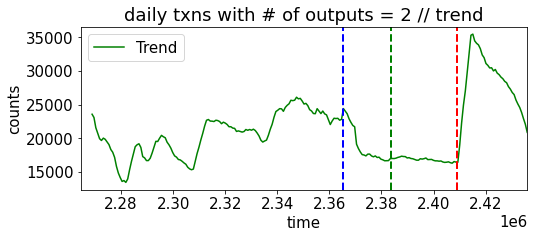

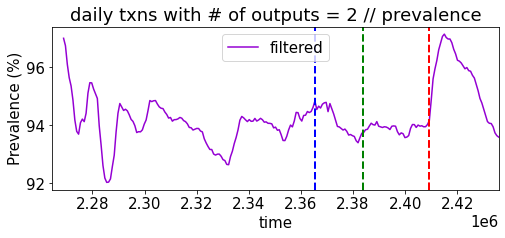

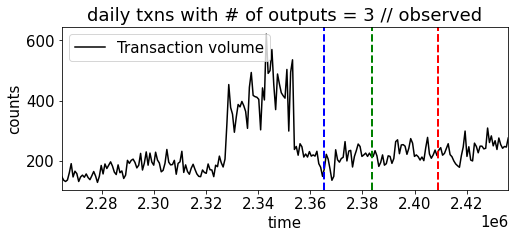

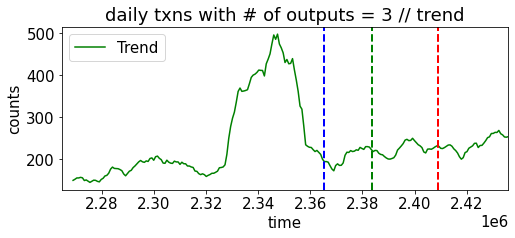

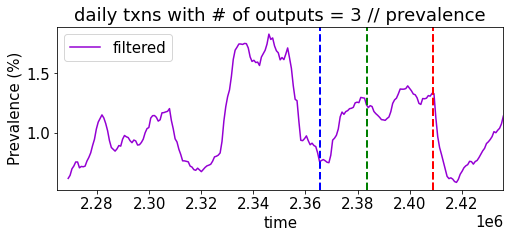

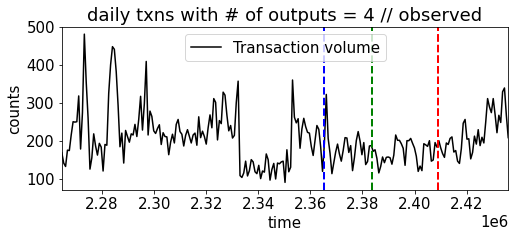

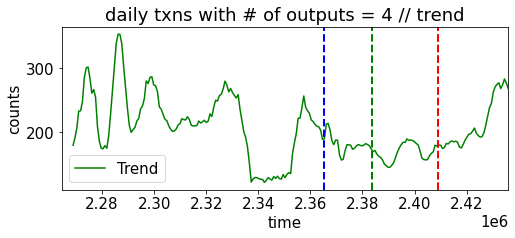

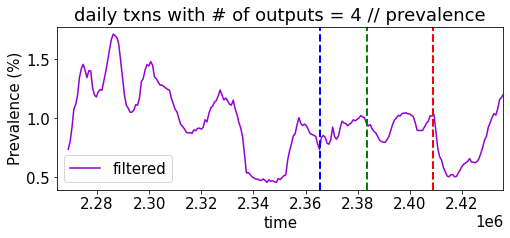

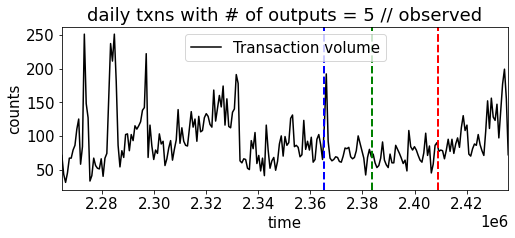

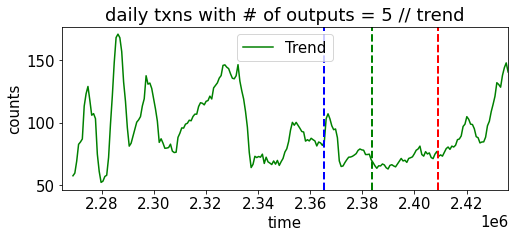

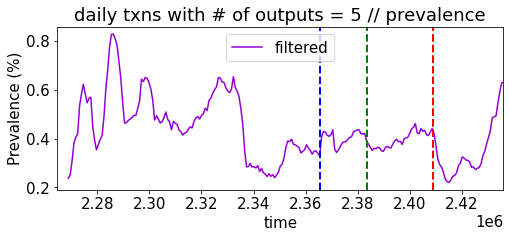

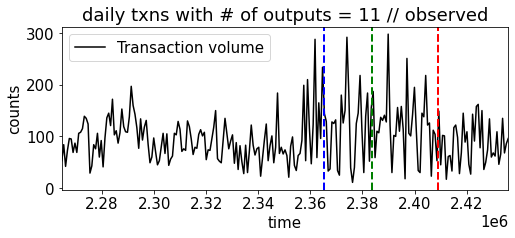

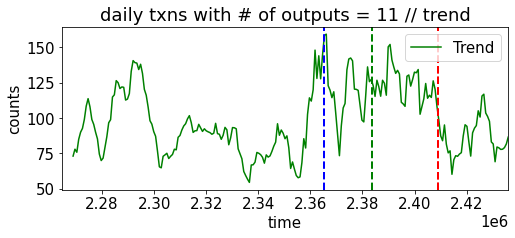

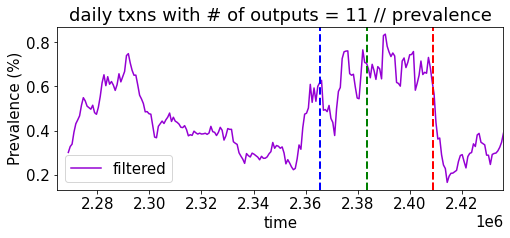

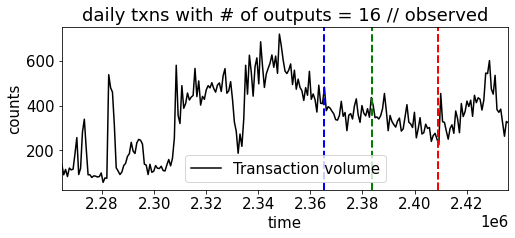

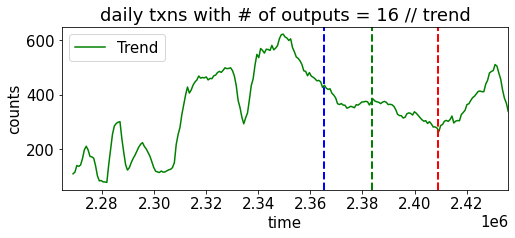

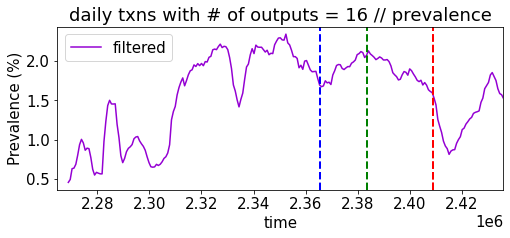

In [25]:
filter_dict: dict = {}
max_num_outputs_to_look_at: int = 5
for n in list(range(2, max_num_outputs_to_look_at + 1)) + [11, 16]:
    filter_dict[f"daily txns with # of outputs = {n}"] = (df['tx_n_vout'] == n)
plot_filtered_versions(df, filter_dict, which_plots=['observed', 'trend', 'comparison'], to_add_lines=False)

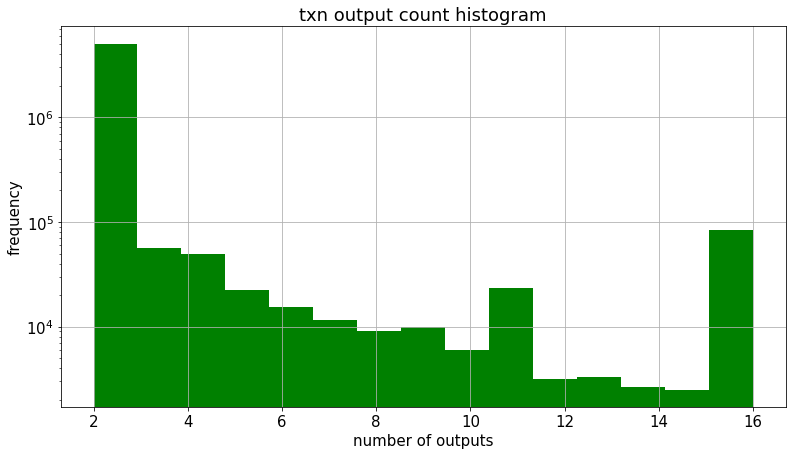

In [26]:
isli.hist(df['tx_n_vout'], bins=15)
plt.yscale('log')
plt.xlabel('number of outputs')
plt.title('txn output count histogram')
plt.grid('on');

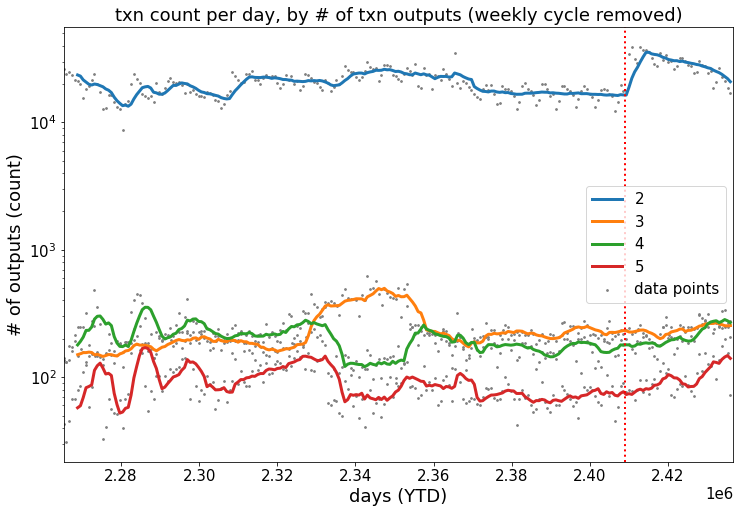

In [27]:
num_inputs_max: int = 5
plt.figure(figsize=(12, 8), facecolor='w')
for n in range(2, num_inputs_max + 1):
    df_filter = (df['tx_n_vout'] == n)
    xx, yy, res, _, ib = apply_filter_and_analyses(df, df_filter=df_filter)
    plt.scatter([x * 720 + ib for x in range(len(res.observed))], res.observed, s=3, color='gray')
    plt.plot([x * 720 + ib for x in range(len(res.observed))], res.trend, linewidth=3);
plt.yscale('log')
plt.legend([str(x) for x in range(2, num_inputs_max + 1)] + ['data points'])
plt.xlabel('days (YTD)', size=18)
plt.ylabel('# of outputs (count)', size=18)
plt.title('txn count per day, by # of txn outputs (weekly cycle removed)', size=18)
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.xlim(isli.bookends(xx, 0));

### Fees

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


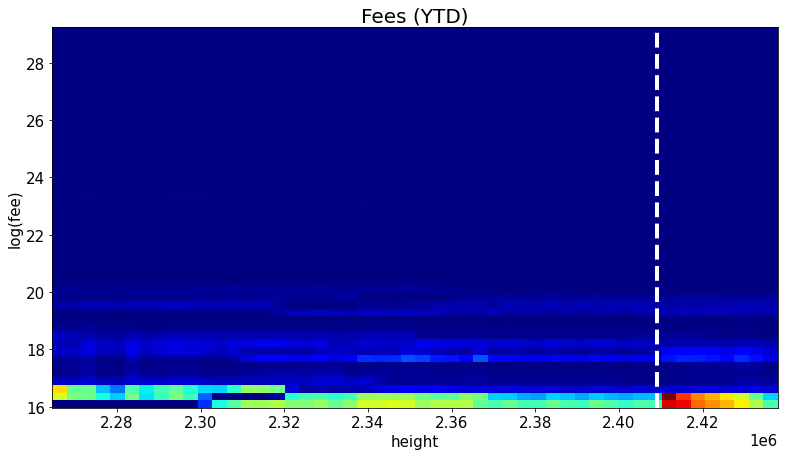

In [28]:
logfees = [np.log(x) for x in df['tx_fee']]
isli.hist2d(df['block_height'], logfees, xlabel='height', ylabel='log(fee)', title='Fees (YTD)')
plt.axvline(x=excess_start_height, color='white', linestyle='--', linewidth=4);

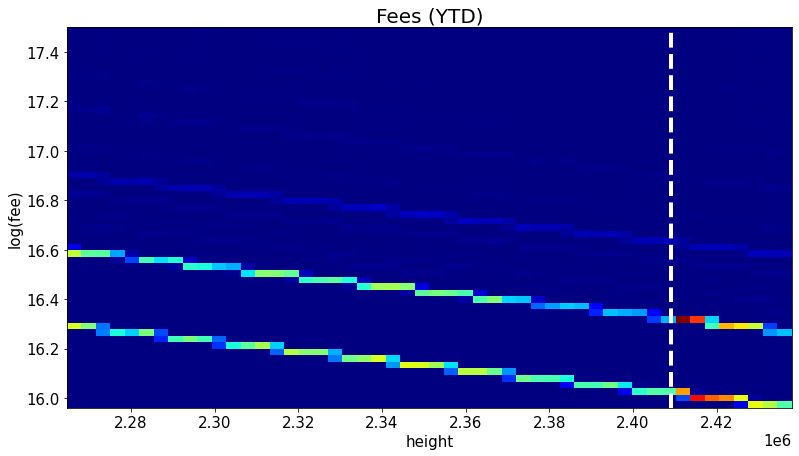

In [29]:
logfees = [np.log(x) for x in df['tx_fee']]
isli.hist2d(df['block_height'], logfees, xlabel='height', ylabel='log(fee)', ylim=(min(logfees), 17.5), bins=(50, 500),
            title='Fees (YTD)')
plt.axvline(x=excess_start_height, color='white', linestyle='--', linewidth=4);

### Len(tx_extra)

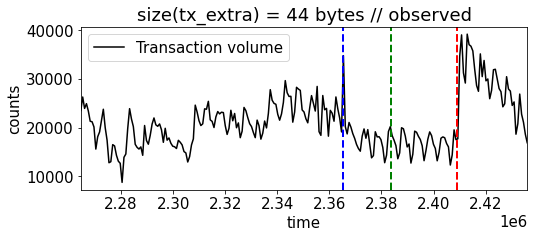

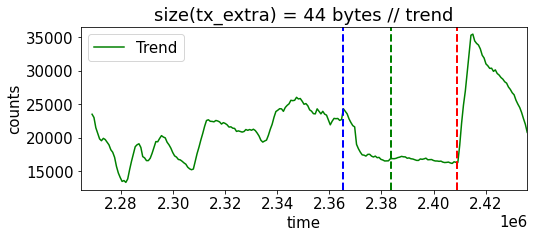

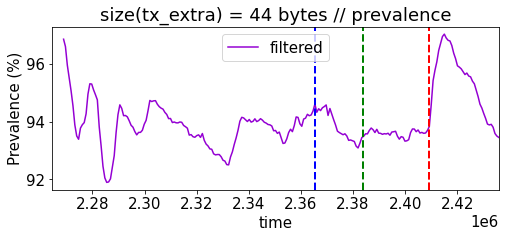

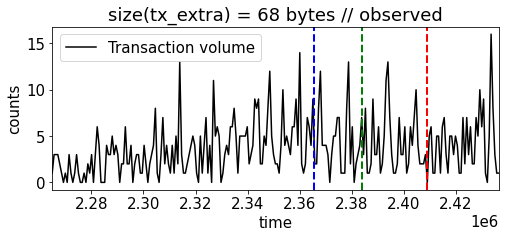

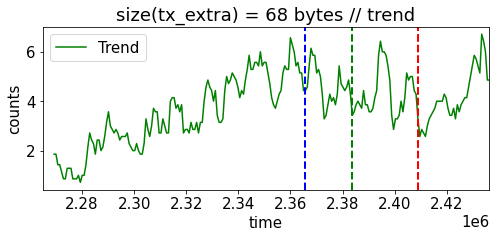

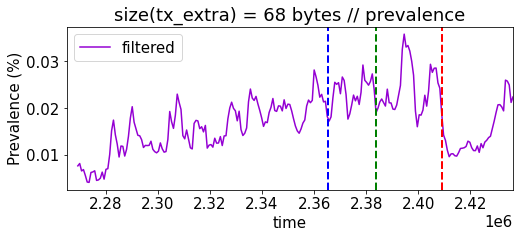

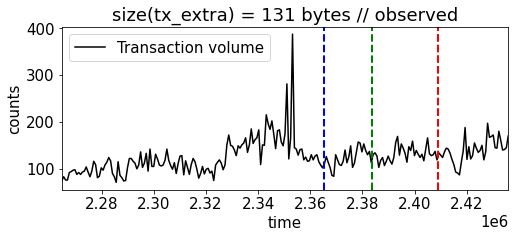

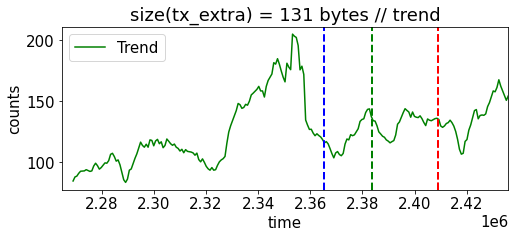

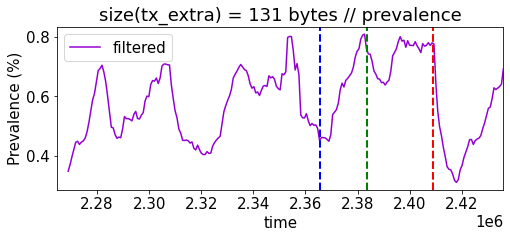

In [30]:
filter_dict: dict = {}
for n in [44, 68, 131]:
    filter_dict[f"size(tx_extra) = {n} bytes"] = (df['tx_len_extra'] == n)
plot_filtered_versions(df, filter_dict, which_plots=['observed', 'trend', 'comparison'])

## Build profile

In [31]:
tx_extra_filter = (df['tx_len_extra'] == 44)
unlock_filter = (df['tx_unlock_time'] == 0)
num_outputs = (df['tx_n_vout'] == 2)
core_fees = (df['tx_fee'] < 20000000)

reference_filter = (((tx_extra_filter & unlock_filter) & num_outputs) & core_fees)

### Plot

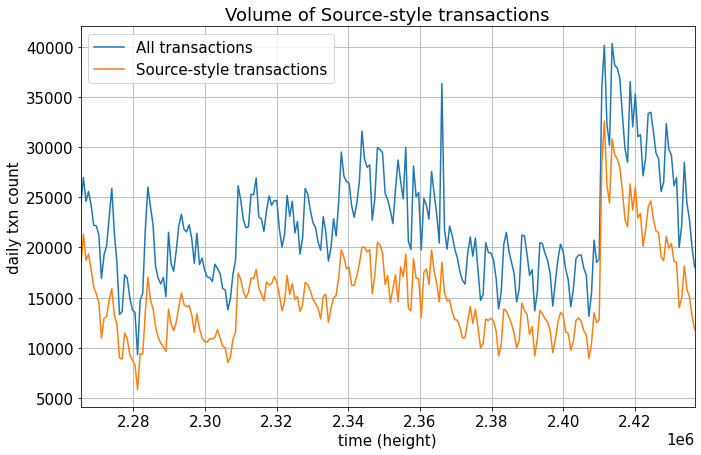

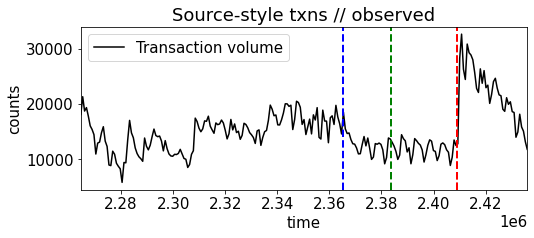

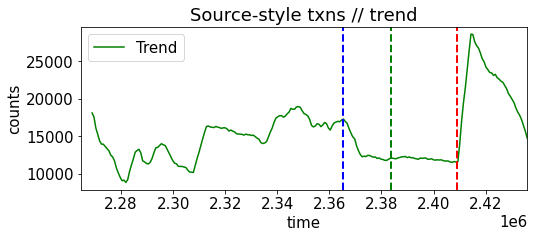

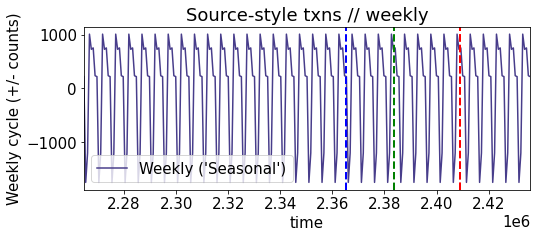

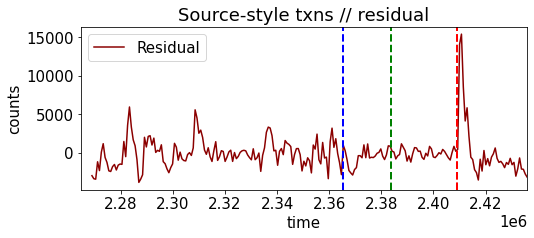

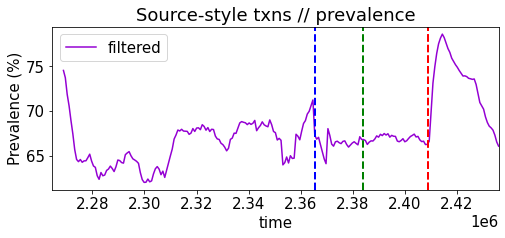

In [32]:
xx, yy, *rest = apply_filter_and_analyses(df)
xx_filtered, yy_filtered, *rest = apply_filter_and_analyses(df, df_filter=reference_filter)
plt.figure(facecolor='w', figsize=standard_figure_size)
plt.xlabel('time (height)')
plt.ylabel('daily txn count')
plt.plot(xx, yy)
plt.plot(xx_filtered, yy_filtered)
plt.legend(['All transactions', 'Source-style transactions'])
plt.title("Volume of Source-style transactions")
plt.grid('on')
plt.xlim(isli.bookends(xx, 0))

plot_filtered_versions(df, {"Source-style txns": reference_filter},
                       which_plots=['observed', 'trend', 'seasonal', 'residual', 'comparison'])

### How much was paid in fees?

In [33]:
df['tx_fee_um'] = [x / 1000000 for x in df['tx_fee']]
df['tx_fee_xmr'] = [x / 10 ** 6 for x in df['tx_fee_um']]
time_window = (2.370e6, max(df['block_height']))

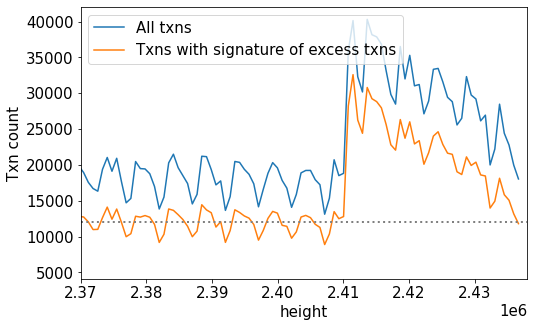

In [34]:
xx, yy, res_all, *rest = apply_filter_and_analyses(df)
xx_filtered, yy_filtered, res_eve, *rest = apply_filter_and_analyses(df, df_filter=reference_filter)
plt.figure(facecolor='w', figsize=(8, 5))
plt.plot(xx, res_all.observed)
plt.plot(xx_filtered, res_eve.observed)
plot_filtered_versions(df, {"eve": reference_filter}, which_plots=[])
plt.legend(['All txns', "Txns with signature of excess txns"]);
plt.xlabel("height")
plt.ylabel('Txn count');
plt.axhline(y=12000, color='gray', linestyle=':', linewidth=2)
plt.xlim(time_window);

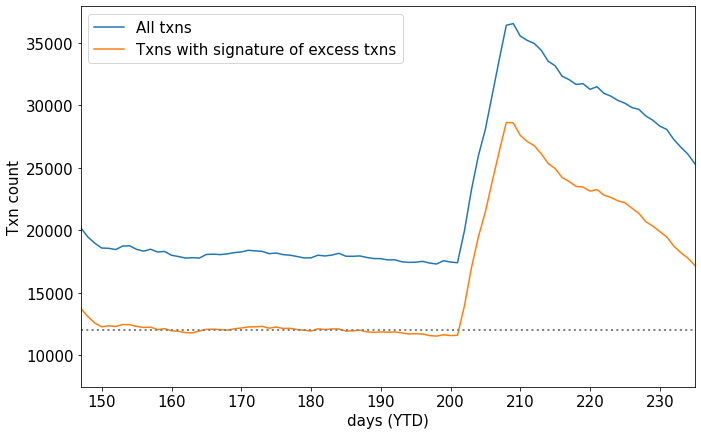

In [35]:
xx, yy, res_all, *rest = apply_filter_and_analyses(df)
xx_filtered, yy_filtered, res_eve, *rest = apply_filter_and_analyses(df, df_filter=reference_filter)
plt.figure(facecolor='w', figsize=standard_figure_size)
plt.plot(range(len(res_all.trend)), res_all.trend)
plt.plot(range(len(res_all.trend)), res_eve.trend)
plot_filtered_versions(df, {"eve": reference_filter}, which_plots=[])
plt.legend(['All txns', "Txns with signature of excess txns"]);
plt.xlabel("days (YTD)")
plt.ylabel('Txn count');
plt.axhline(y=12000, color='gray', linestyle=':', linewidth=2)
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.xlim((235 - 88, 235));

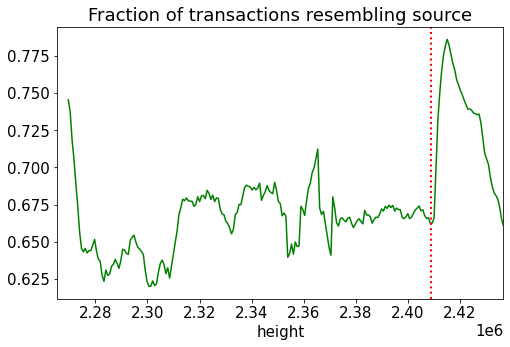

In [36]:
xx, yy, res_all, *rest = apply_filter_and_analyses(df)
xx_filtered, yy_filtered, res_eve, *rest = apply_filter_and_analyses(df, df_filter=reference_filter)
plt.figure(facecolor='w', figsize=(8, 5))
plt.plot(xx, [x[1] / x[0] for x in zip(res_all.trend, res_eve.trend)], color='green')
plot_filtered_versions(df, {"eve": reference_filter}, which_plots=[])
plt.xlabel("height")
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.title("Fraction of transactions resembling source")
plt.xlim(isli.bookends(xx, 0));

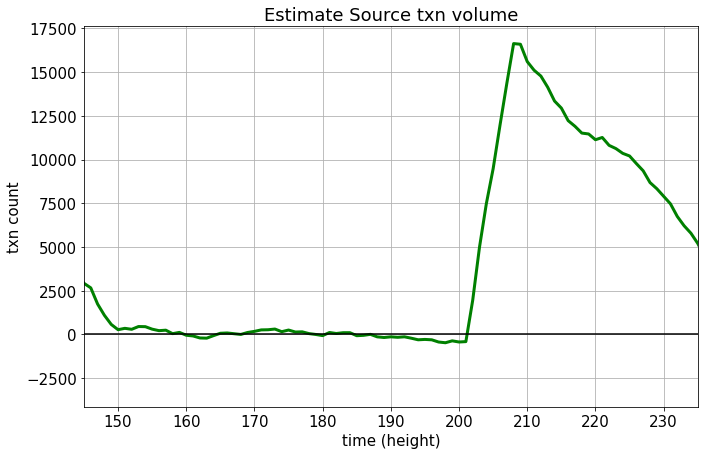

In [37]:
eve_style_offset = [x - 12000 for x in res_eve.trend]
plt.figure(facecolor='w', figsize=standard_figure_size)
plt.plot(eve_style_offset, linewidth=3, color='g')
plt.xlabel('time (height)')
plt.ylabel('txn count')
plt.axhline(y=0, color='k')
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.title("Estimate Source txn volume")
plt.grid('on')
plt.xlim((235 - 90, 235));

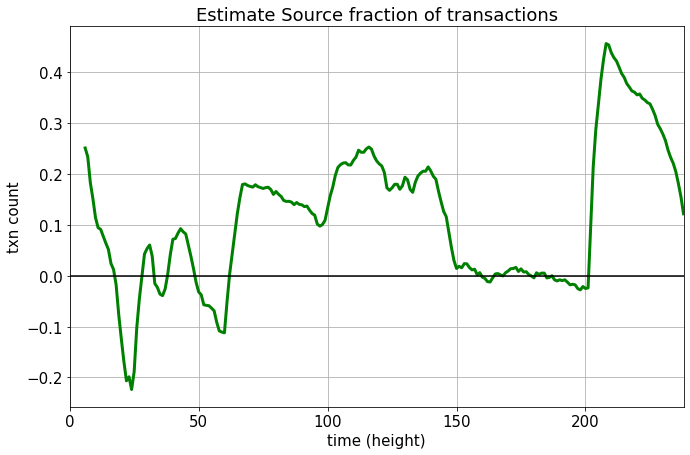

In [38]:
eve_ratio = [x[0] / x[1] for x in zip(eve_style_offset, res_all.trend)]
plt.figure(facecolor='w', figsize=standard_figure_size)
plt.plot(eve_ratio, linewidth=3, color='g')
plt.xlabel('time (height)')
plt.ylabel('txn count')
plt.axhline(y=0, color='k')
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.title("Estimate Source fraction of transactions")
plt.grid('on')
plt.xlim((0, 238));

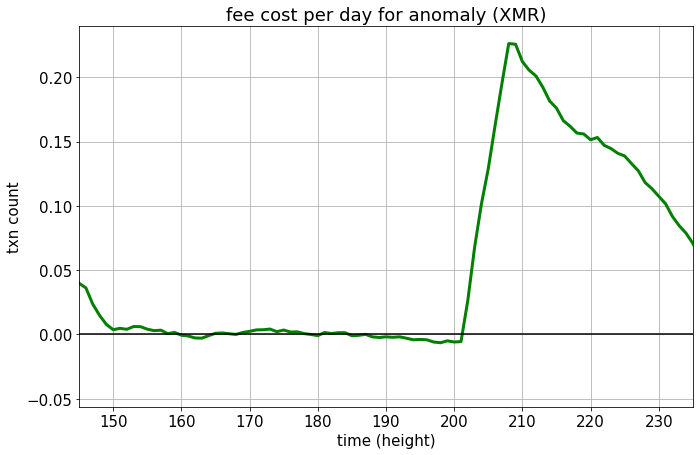

In [39]:
avg_txn_fee_xmr: float = 0.000013603680375478943
estimated_fees_xmr = [x * avg_txn_fee_xmr for x in eve_style_offset]
plt.figure(facecolor='w', figsize=standard_figure_size)
plt.plot(estimated_fees_xmr, linewidth=3, color='g')
plt.xlabel('time (height)')
plt.ylabel('txn count')
plt.axhline(y=0, color='k')
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.title("fee cost per day for anomaly (XMR)")
plt.grid('on')
plt.xlim((195, 235))
plt.xlim((235 - 90, 235));

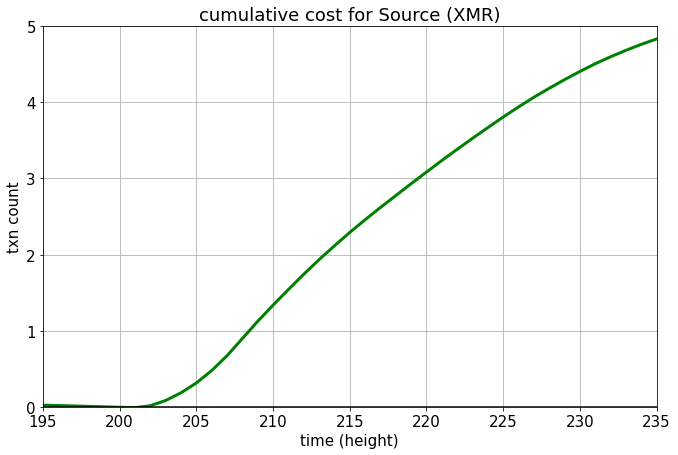

In [40]:
avg_txn_fee_xmr = 0.000013603680375478943
cumsum_estimated_fees_xmr = np.nancumsum(estimated_fees_xmr)
cumsum_fee_offset = -5.1
corrected_cumsum = [x + cumsum_fee_offset for x in cumsum_estimated_fees_xmr]
plt.figure(facecolor='w', figsize=standard_figure_size)
plt.plot(corrected_cumsum, linewidth=3, color='g')
plt.xlabel('time (height)')
plt.ylabel('txn count')
plt.axhline(y=0, color='k')
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.title("cumulative cost for Source (XMR)")
plt.grid('on')
plt.xlim((195, 235))
plt.ylim([0, 5]);

In [41]:
fee_per_day_total = list()
eve_share_fees_xmr = list()
for i in range(len(eve_ratio)):
    left_edge = xx[i]
    right_edge = left_edge + 720
    df_rel = df[df['block_height'].between(left_edge, right_edge)]
    fee_sum = sum(df_rel['tx_fee_xmr'])
    fee_per_day_total.append(fee_sum)
    eve_share_fees_xmr.append(fee_sum * eve_ratio[i])

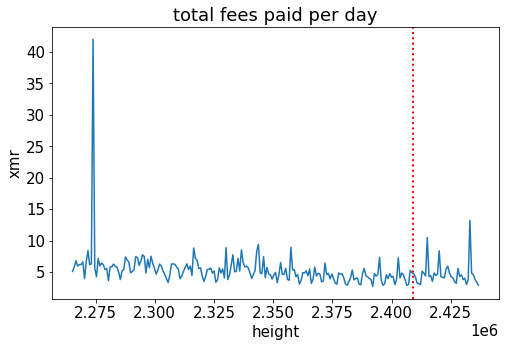

In [42]:
plt.figure(facecolor='w', figsize=(8, 5))
plt.plot(xx, fee_per_day_total)
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.title("total fees paid per day")
plt.ylabel('xmr')
plt.xlabel('height');

In [43]:
xmr_value: float = 200
eve_cost_xmr: float = max(cumsum_estimated_fees_xmr) + cumsum_fee_offset

print(f"ROUGH estimate of cost of excess: {round(eve_cost_xmr, 2)} XMR (or at exchange rate of {xmr_value}, about ${int(round(eve_cost_xmr * xmr_value, 2))}")

ROUGH estimate of cost of excess: 4.98 XMR (or at exchange rate of 200, about $996


### Rough estimate number of txns

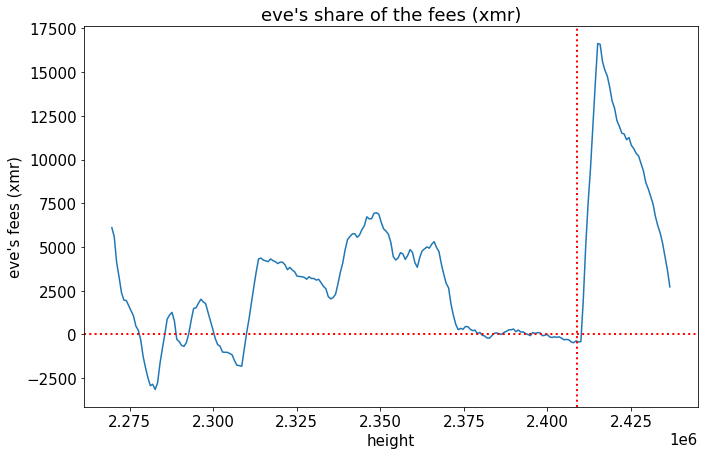

In [44]:
plt.figure(facecolor='w', figsize=standard_figure_size)
plt.plot(xx, eve_style_offset)
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.axhline(y=0, color='r', linestyle=':', linewidth=2)
plt.title("eve's share of the fees (xmr)")
plt.ylabel("eve's fees (xmr)")
plt.xlabel('height');

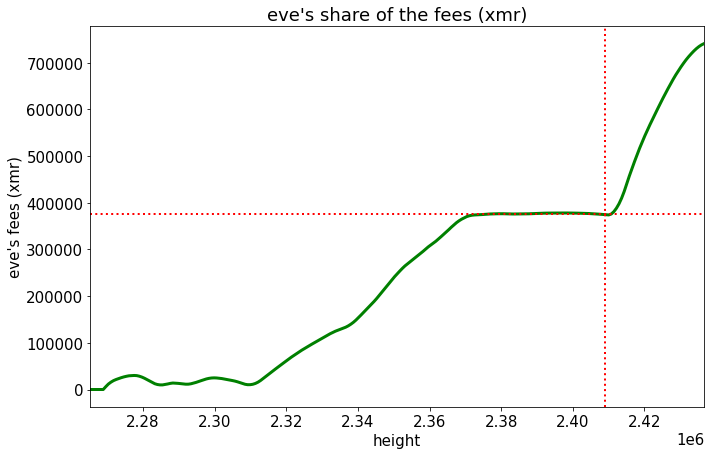

In [45]:
txn_count_offset = 375000
plt.figure(facecolor='w', figsize=standard_figure_size)
plt.plot(xx, np.nancumsum(eve_style_offset), linewidth=3, color='g')
plt.axvline(x=excess_start_height, color='r', linestyle=':', linewidth=2)
plt.axhline(y=txn_count_offset, color='r', linestyle=':', linewidth=2)
plt.title("eve's share of the fees (xmr)")
plt.ylabel("eve's fees (xmr)")
plt.xlabel('height')
plt.xlim(isli.bookends(xx, 0));

In [46]:
txns_from_eve: int = int(round(max(np.nancumsum(eve_style_offset)) - txn_count_offset, -3))
print(f"Source generated about {txns_from_eve} transactions")

Source generated about 366000 transactions


## Youngest member analysis

In [47]:
data_file_path: str = os.path.join(os.path.curdir,  'data')
data_file_name: str = 'Noise-reduced-measure-of-youngest-ring-member.csv'  # Thanks @ Rucknium
dfm: pd.DataFrame = pd.read_csv(os.path.join(data_file_path, data_file_name))
dfm.head();

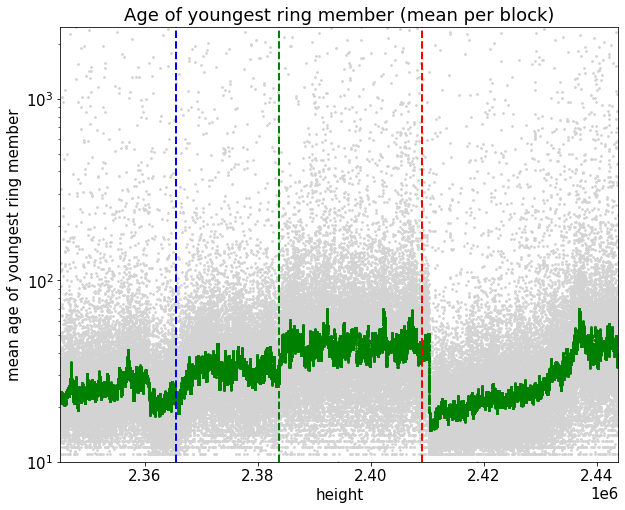

In [48]:
plt.figure(facecolor='w', figsize=(10, 8))
plt.scatter(dfm['source_height'], dfm['mean'], color='lightgray', s=3)
plt.scatter(dfm['source_height'], dfm['rolling_mean'], color='green', s=3)
plt.ylim([10, 2500])
add_lines()
plt.yscale('log')
plt.xlabel('height')
plt.ylabel('mean age of youngest ring member')
plt.xlim(isli.bookends(dfm['source_height'], 0))
plt.title('Age of youngest ring member (mean per block)');

## Examine ring member ages

### Import the data

In [49]:
timing_data_file_path: str = os.path.join(os.path.curdir,  'data')
timing_data_file_name: str = 'ring_data.csv'  # Thanks @ Neptune Research
dfr = pd.read_csv(os.path.join(timing_data_file_path, timing_data_file_name))
dfr['age_member'] = dfr['source_height'] - dfr['ringmember_height']
dfr = dfr.rename(columns={"source_height": "height_sig", "ringmember_height": "height_member"})
dfr.head()

height_sig  source_tx_index  source_vin_index  ringmember_index  \
0     2345000               13                 1                 1   
1     2345000               13                 1                 2   
2     2345000               13                 1                 3   
3     2345000               13                 1                 4   
4     2345000               13                 1                 5   

   height_member  age_member  
0        2204657      140343  
1        2342510        2490  
2        2343048        1952  
3        2343764        1236  
4        2343793        1207

### Visualize

Visualize time vs time

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


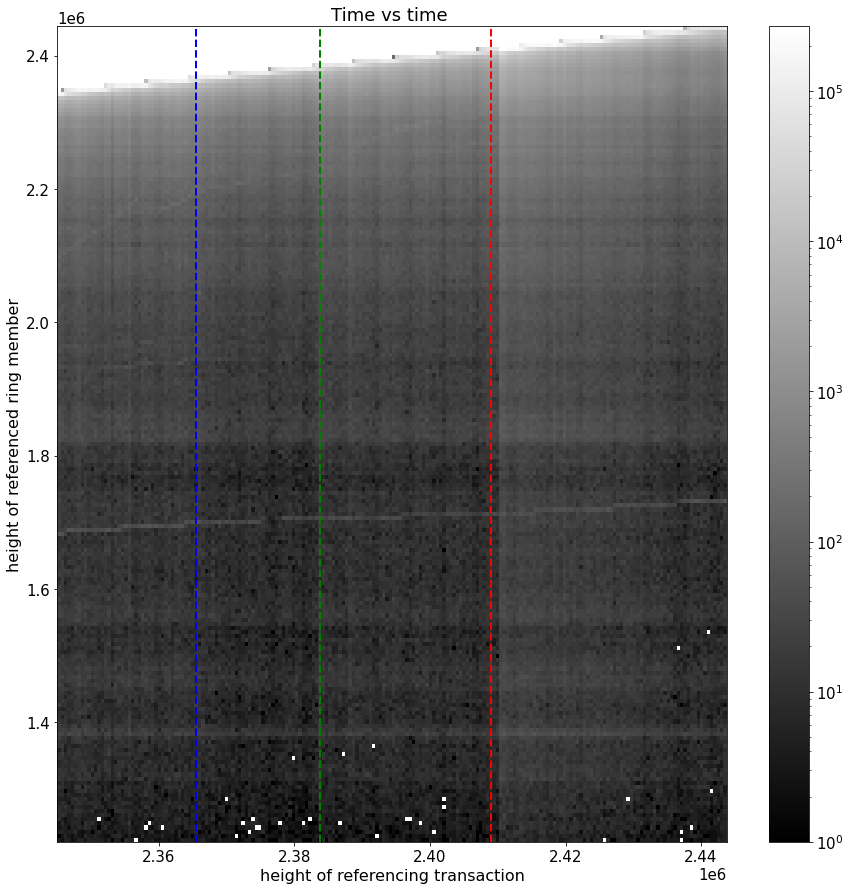

In [50]:
plt.figure(facecolor='w', figsize=(15, 15))
par = plt.hist2d(dfr['height_sig'], dfr['height_member'],
                 norm=matplotlib.colors.LogNorm(), cmap=matplotlib.cm.gray, bins=(200, 200))
plt.xlabel('height of referencing transaction', size=16)
plt.ylabel('height of referenced ring member', size=16)
plt.title('Time vs time ')
plt.colorbar()
add_lines();

Visualize age of ring members

/tmp/ipykernel_153442/3388308100.py:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  par = plt.hist2d(dfr['height_sig'], dfr['height_member'],


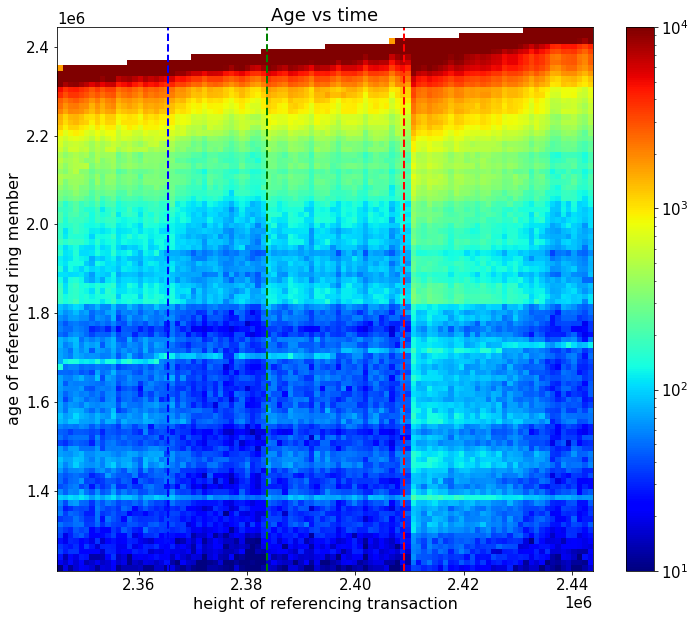

In [51]:
plt.figure(facecolor='w', figsize=(12, 10))
df_filter = (dfr['height_member'] > 0)
par = plt.hist2d(dfr['height_sig'], dfr['height_member'],
                 norm=matplotlib.colors.LogNorm(), cmap=matplotlib.cm.jet, bins=(100, 100), vmin=10, vmax=10 ** 4)
plt.xlabel('height of referencing transaction', size=16)
plt.ylabel('age of referenced ring member', size=16)
plt.title('Age vs time')
plt.colorbar()
add_lines();

### Normalize the data

In [52]:
def round_down(num, divisor):
    return num - (num % divisor)


# Add rounded timebase

bin_width_height: int = 720 // 4
dfr['sig_day_height'] = [round_down(x, bin_width_height) for x in dfr['height_sig']]
dfr.head()

# Get weights

bin_edges: list = list(set(dfr['sig_day_height']))
bin_edges.sort()
bin_edges.append(max(bin_edges) + bin_width_height)

# Calculate daily counts
sig_hist_counts, sig_hist_edges = np.histogram(dfr.sig_day_height, bins=bin_edges)

# Encode into a dict
counts_dict: dict = dict()
for i in range(len(sig_hist_counts)):
    counts_dict[sig_hist_edges[i]] = sig_hist_counts[i]

# Add as a column in the data frame
dfr['day_counts'] = [counts_dict[x] for x in dfr['sig_day_height']]
dfr['inverse_counts'] = [1 / x for x in dfr['day_counts']];

Now we can visualize, normalized by transaction volume, first the timing plot again (zoomed out and zoomed in)

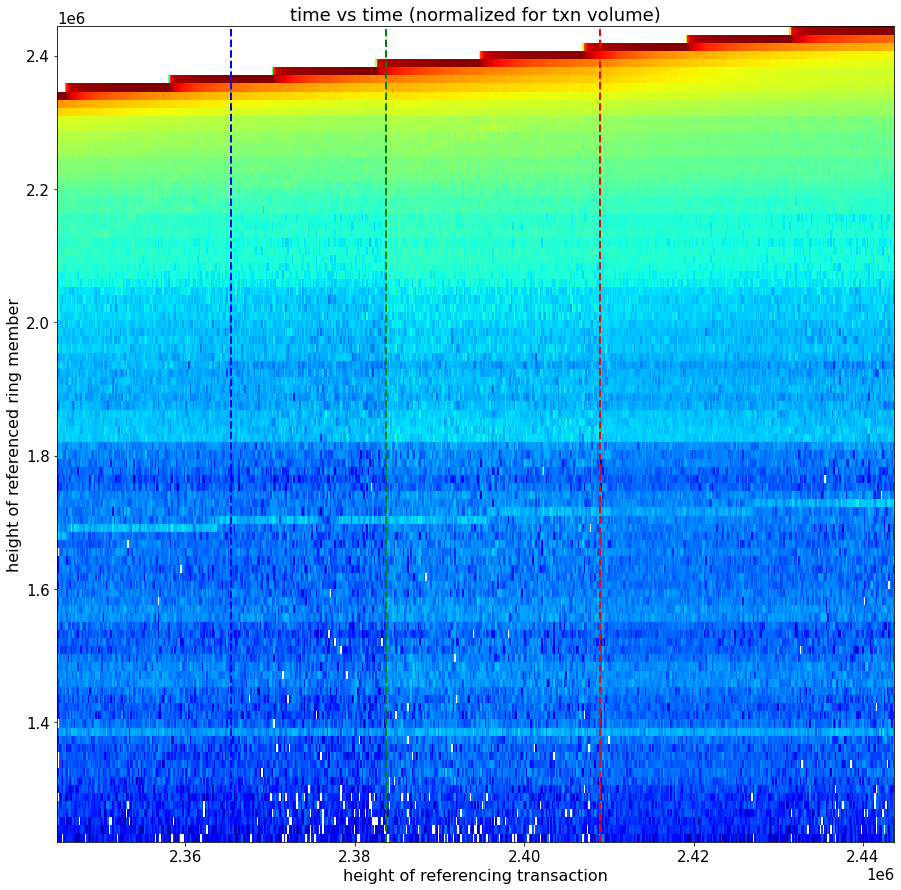

In [53]:
plt.figure(facecolor='w', figsize=(15, 15))
par = plt.hist2d(dfr['sig_day_height'], dfr['height_member'], weights=dfr['inverse_counts'],
                 bins=(len(bin_edges) - 1, 100),
                 norm=matplotlib.colors.LogNorm(), cmap=matplotlib.cm.jet)
plt.xlabel('height of referencing transaction', size=16)
plt.ylabel('height of referenced ring member', size=16)
plt.title('time vs time (normalized for txn volume)')
add_lines();

/tmp/ipykernel_153442/531710510.py:2: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  par = plt.hist2d(dfr['sig_day_height'], dfr['height_member'], weights=dfr['inverse_counts'],


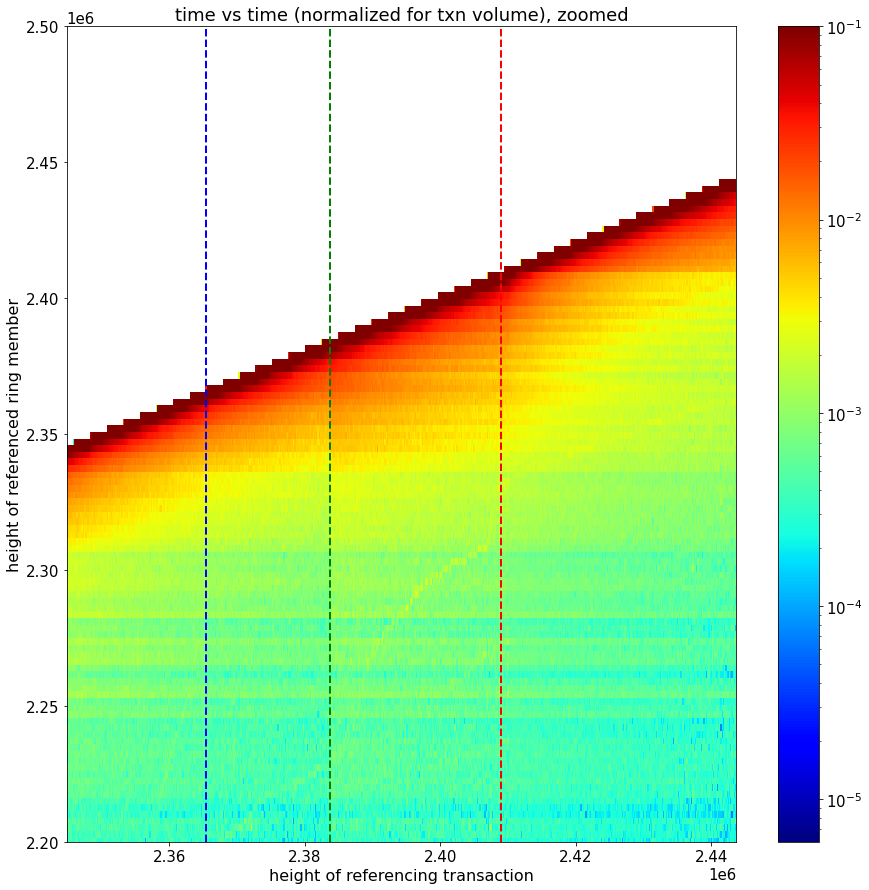

In [54]:
plt.figure(facecolor='w', figsize=(15, 15))
par = plt.hist2d(dfr['sig_day_height'], dfr['height_member'], weights=dfr['inverse_counts'],
                 bins=(len(bin_edges) - 1, 500),
                 norm=matplotlib.colors.LogNorm(), cmap=matplotlib.cm.jet, vmax=10 ** -1)
plt.xlabel('height of referencing transaction', size=16)
plt.ylabel('height of referenced ring member', size=16)
plt.title('time vs time (normalized for txn volume), zoomed')
plt.ylim((2.2e6, 2.5e6))
add_lines()
plt.colorbar();

We can also apply the volume normalization to the age plots (top: linear, bottom: log y-axis)

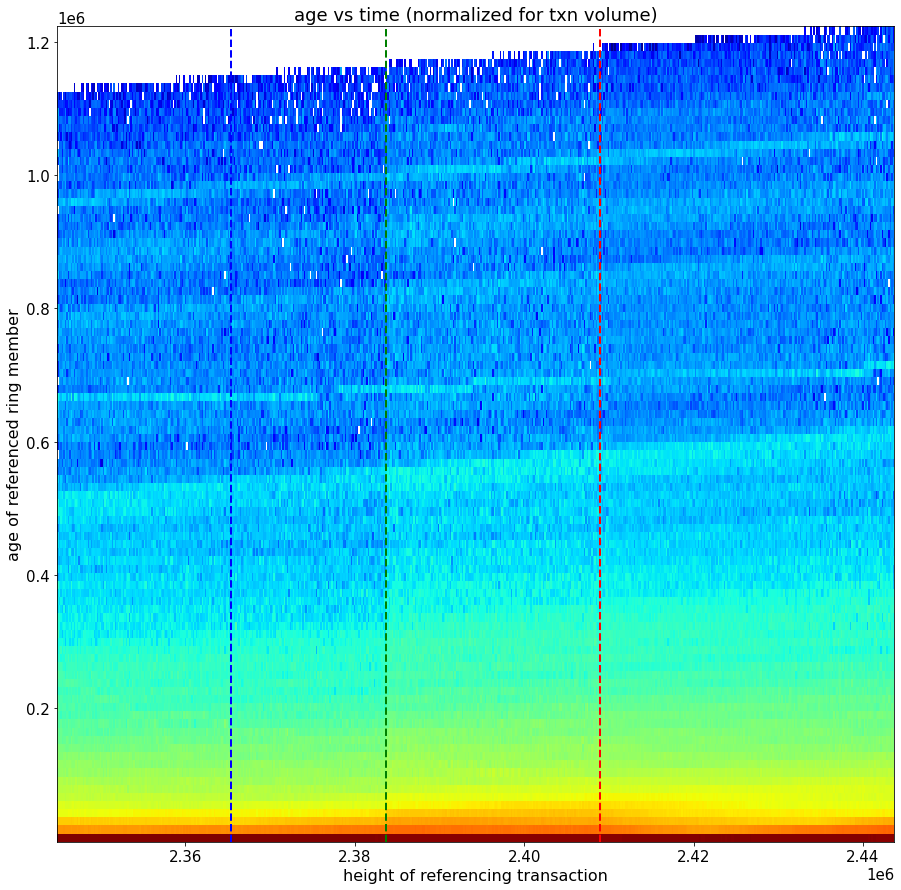

In [55]:
plt.figure(facecolor='w', figsize=(15, 15))
par = plt.hist2d(dfr['sig_day_height'], dfr['age_member'], weights=dfr['inverse_counts'],
                 bins=(len(bin_edges) - 1, 100),
                 norm=matplotlib.colors.LogNorm(), cmap=matplotlib.cm.jet)
plt.xlabel('height of referencing transaction', size=16)
plt.ylabel('age of referenced ring member', size=16)
plt.title('age vs time (normalized for txn volume)')
add_lines();

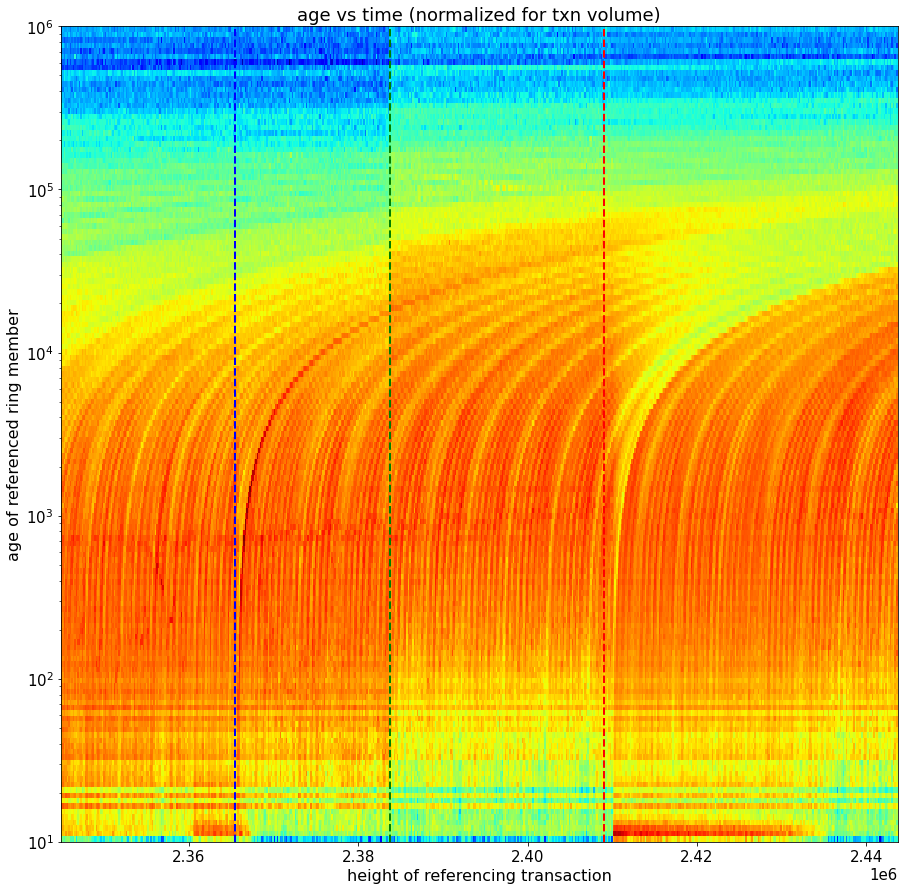

In [56]:
plt.figure(facecolor='w', figsize=(15, 15))
ybins = np.logspace(1, 6, 150)
par = plt.hist2d(dfr['sig_day_height'], dfr['age_member'], weights=dfr['inverse_counts'],
                 bins=(len(bin_edges) - 1, ybins),
                 norm=matplotlib.colors.LogNorm(), cmap=matplotlib.cm.jet)
plt.xlabel('height of referencing transaction', size=16)
plt.ylabel('age of referenced ring member', size=16)
plt.title('age vs time (normalized for txn volume)')
add_lines()
plt.yscale('log');

Look at young ring members before and during the anomaly (top: full scale, bottom: zoomed in for control + anomaly)

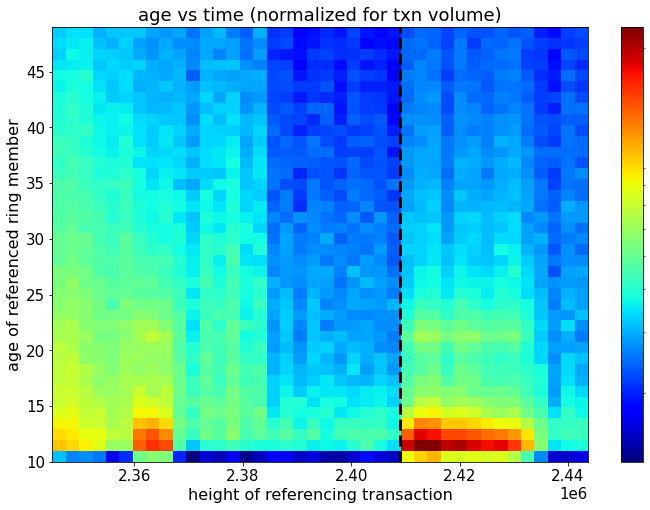

In [57]:
plt.figure(facecolor='w', figsize=(12, 8))
df_filter = (dfr['sig_day_height'] > 1.39e6) & (dfr['age_member'] < 50)
par = plt.hist2d(dfr[df_filter]['sig_day_height'], dfr[df_filter]['age_member'],
                 weights=dfr[df_filter]['inverse_counts'],
                 norm=matplotlib.colors.LogNorm(), cmap=matplotlib.cm.jet, bins=(40, 40))
plt.xlabel('height of referencing transaction', size=16)
plt.ylabel('age of referenced ring member', size=16)
plt.title('age vs time (normalized for txn volume)')
plt.axvline(x=excess_start_height, c='k', linewidth=3, linestyle='--')
cbar = plt.colorbar()
cbar.set_ticks([]);

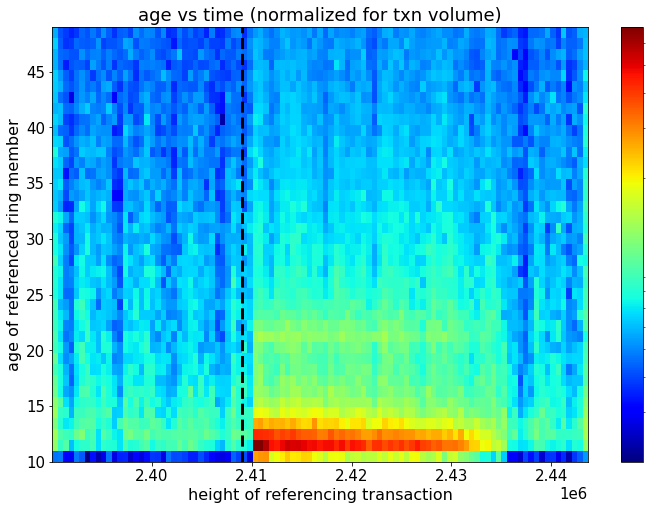

In [58]:
plt.figure(facecolor='w', figsize=(12, 8))
df_filter = (dfr['sig_day_height'] > 2.39e6) & (dfr['age_member'] < 50)
par = plt.hist2d(dfr[df_filter]['sig_day_height'], dfr[df_filter]['age_member'],
                 weights=dfr[df_filter]['inverse_counts'],
                 norm=matplotlib.colors.LogNorm(), cmap=matplotlib.cm.jet, bins=(99, 40))
plt.xlabel('height of referencing transaction', size=16)
plt.ylabel('age of referenced ring member', size=16)
plt.title('age vs time (normalized for txn volume)')
cbar = plt.colorbar()
cbar.set_ticks([])
plt.axvline(x=excess_start_height, c='k', linewidth=3, linestyle='--');